In [1]:
#uncomment the following line of code if any of the following libraries are not installed locally
#!pip install psycopg2
#!pip install sqlalchemy
#!pip install pandas
#!pip install datetime
#!pip install geopy
#!pip install tqdm
#!pip install bs4
#!pip install requests
#!pip install urllib
#!pip install json

#importing the necessary 
import pandas as pd
from datetime import date
import json
from pandas import json_normalize
import matplotlib.pyplot as plt

In [2]:
#################################################################################
#GETTING DEMOGRAPHICS DATA AND PREPARING DATAFRAME FOR LOADING INTO THE DATABASE#
#################################################################################
#getting data from the preprocessed csv file for 2022
df_date_2021=pd.read_csv('../raw_data/census_2021.csv')
df_date_2021= df_date_2021.drop(columns = ['Unnamed: 0'])
#getting the data fromt the preprocessed csv file for 2016
df_date_2016=pd.read_csv('../raw_data/census_2016.csv')
df_date_2016= df_date_2016.drop(columns = ['Unnamed: 0'])
df_date_2016.dissemination_area=df_date_2016.dissemination_area.astype('int64')
#getting the data fromt the preprocessed csv file for 2011
df_date_2011=pd.read_csv('../raw_data/census_2011.csv')
df_date_2011= df_date_2011.drop(columns = ['Unnamed: 0'])
#copy the median_household_income from the next year since 2011 census doesn't contain this columns
#as stated in our assumptions
df_date_2011= df_date_2011.drop(columns = ['median_household_income'])
df_date_2011=df_date_2011.merge(df_date_2016[['dissemination_area', 'median_household_income']], on = 'dissemination_area', how = 'left')
#reordering the rows to match the other dataframes
df_date_2011=df_date_2011[['demographics_key', 'dissemination_area','population','average_age','median_age',
                'total_dwellings','average_household_size','median_household_income',
                'mother_tongue_official_percentage','mother_tongue_unofficial_percentage','census_year']]
#combine the three census years together into one dataframe
frames = [df_date_2011, df_date_2016, df_date_2021]
result = pd.concat(frames)
#Removed the average age column as the average age was not reported in the 2011 census profilesà
#and we had the data from the 
result=result.drop(columns=['average_age'])
#removed the rows where the population through mother_tongue_unofficial was null
result=result.dropna(subset=['population','average_household_size','median_household_income',
                             'mother_tongue_official_percentage','mother_tongue_unofficial_percentage']).reset_index(drop = True) 
#convert demographics_key into an integer
result.demographics_key=result.demographics_key.astype('int64')
#convert population into an integer
result.population=result.population.astype('int64')
#convert date to an integer
result.census_year=result.census_year.astype('int64')
#convert total_dwellings to int
result.total_dwellings=result.total_dwellings.astype('int64')

In [3]:
#############################################################################
#GETTING LOCATION DATA AND PREPARING DATAFRAME FOR LOADING INTO THE DATABASE#
#############################################################################

#load the data
unique_locations=pd.read_csv("../raw_data/dim_location.csv")
#remove the pandas generated index row
unique_locations=unique_locations.drop(columns=["Unnamed: 0"])
#renamed the rows to match with the SQL names
unique_locations= unique_locations.rename(columns={'Location_key':'location_key','Longitude':'longitude','Latitude':'latitude',
'Intersection':'nearest_intersection','Level_Of_Origin':'floor_level','Postal_Code':'postal_code','Dissemination_area':'dissemination_area'})
#Basement are denoted with a B which I replaced with a negative sign since the database requires an smallint 
unique_locations['floor_level'] =unique_locations['floor_level'].apply(lambda x: x.replace("B", "-"))
#removes duplicates of the primary key in the database (precision is within 10m
unique_locations.drop_duplicates(subset='location_key', keep='first', inplace=True)
#For one row, the dissemination_area that was obtained was a region name instead so the row was removed from the dataframe
unique_locations=unique_locations[unique_locations['dissemination_area'] != 'North Battleford']

In [4]:
############################################################################
#GETTING WEATHER DATA AND PREPARING DATAFRAME FOR LOADING INTO THE DATABASE#
############################################################################

#create a dataframe
weather=pd.read_csv("../raw_data/Weather.csv")
#rename columns to be the same as the ones in the SQL code
weather= weather.rename(columns={'Key':'weather_key','TFS_Alarm_Time':'datetime',
                                          'Latitude':'latitude','Longitude':'longitude',
                                          'StartTime':'start_time' ,'EndTime':'end_time',
                                          'temp':'temperature', 'dwpt':'dewpoint',
                                          'rhum':'relative_humidity', 'prcp':'precipitaion',
                                          'snow':'snow','wdir':'wind_direction',
                                          'wspd':'wind_speed'
})
#remove any duplicates
weather.drop_duplicates(subset='weather_key', keep='first', inplace=True)

In [5]:
#########################################################################
#GETTING DATE DATA AND PREPARING DATAFRAME FOR LOADING INTO THE DATABASE#
#########################################################################

# Holiday dates obtained from https://www.statutoryholidays.com/
def getHolidayName(df_date):
    thisdate = date(df_date["year"], df_date["month"], df_date["day"])
    if thisdate == date(df_date["year"], 1, 1):
        return "New year's day"
    elif df_date["month"] == 2 and df_date["day_of_week"] == 1 and df_date["day"] >= 15 and df_date["day"] <= 21:
        return "Family day"
    elif thisdate in [date(2011, 4, 22), date(2012, 4, 6), date(2013, 3, 29),
                  date(2014, 4, 18), date(2015, 4, 3), date(2016, 3, 25),
                  date(2017, 4, 14), date(2018, 3, 30), date(2019, 4, 19),
                  date(2020, 4, 10), date(2021, 4, 2)]:
        return "Good friday"
    elif thisdate in [date(2011, 4, 24), date(2012, 4, 8), date(2013, 3, 31),
                  date(2014, 4, 20), date(2015, 4, 5), date(2016, 3, 27),
                  date(2017, 4, 16), date(2018, 4, 1), date(2019, 4, 21),
                  date(2020, 4, 12), date(2021, 4, 4)]:
        return "Easter sunday"
    elif thisdate == date(df_date["year"], 7, 1):
        return "Canada day"
    elif df_date["month"] == 8 and df_date["day_of_week"] == 1 and df_date["day"] <= 7:
        return "Civic holiday"
    elif df_date["month"] == 9 and df_date["day_of_week"] == 1 and df_date["day"] <= 7:
        return "Labour day"
    elif df_date["month"] == 10 and df_date["day_of_week"] == 1 and df_date["day"] >= 8 and df_date["day"] <=14:
        return "Thanksgiving"
    elif thisdate == date(df_date["year"], 12, 25):
        return "Christmas day"
    elif thisdate == date(df_date["year"], 12, 26):
        return "Boxing day"
    elif thisdate == date(df_date["year"], 2, 14):
        return "Valentines day"
    elif thisdate == date(df_date["year"], 3, 17):
        return "St. Patricks day"
    elif thisdate == date(df_date["year"], 10, 31):
        return "Halloween"
    
pd.set_option('display.max_columns', None)

# Loading the raw data
df_date = pd.read_csv("../raw_data/fire_incidents_data.csv")

# Grabbing the time column
df_date = df_date[['TFS_Alarm_Time']]
# Calculating the values for the columns
df_date["date_key"] = df_date["TFS_Alarm_Time"].str.replace("-","").str.replace("T","").str.replace(":","").astype('int64')
df_date["datetime"] = df_date["TFS_Alarm_Time"]
df_date["year"] = df_date["datetime"].apply(lambda thisdate: thisdate[0:4]).astype('int')
df_date["month"] = df_date["datetime"].apply(lambda thisdate: thisdate[5:7]).astype('int')
df_date["day"] = df_date["datetime"].apply(lambda thisdate: thisdate[8:10]).astype('int')
df_date["hour"] = df_date["datetime"].apply(lambda thisdate: thisdate[11:13]).astype('int')
df_date["minute"] = df_date["datetime"].apply(lambda thisdate: thisdate[14:16]).astype('int')
df_date["day_of_week"] = df_date["datetime"].apply(lambda thisdate: date(int(thisdate[0:4]), int(thisdate[5:7]), int(thisdate[8:10])).weekday()+1).astype('int')
df_date["weekend"] = df_date["day_of_week"].apply(lambda thisdate: True if thisdate >= 6 else False)
df_date["time_of_day"] = df_date["hour"].apply(lambda thishour: 'night' if thishour < 6 else ('morning' if thishour < 12 else ('afternoon' if thishour < 18 else 'evening')))
df_date["census_year"] = df_date["year"].apply(lambda thisyear: 2011 if thisyear <= 2011 else (2016 if thisyear <= 2016 else 2021))
df_date["holiday"] = df_date.apply(getHolidayName, axis = 1)
df_date["is_holiday"] = df_date["holiday"].apply(lambda thisholiday: True if thisholiday else False)

# Dropping the original column
df_date = df_date.drop(columns=["TFS_Alarm_Time"])

In [6]:
##############################################################################
#GETTING FIRE WARD DATA AND PREPARING DATAFRAME FOR LOADING INTO THE DATABASE#
##############################################################################

df = pd.read_csv("../raw_data/fire-station-locations.csv")
b = df["geometry"][0]

b = b.replace("\'", "\"")
b= b.replace("(", "[")
b= b.replace(")", "]")

# b = '{"type": "Point", "coordinates": [-79.2428700353868, 43.8239927252015]}'

c = json.loads(b)
df['geometry'] = df['geometry'].apply(lambda x: x.replace("\'", "\""))
df['geometry'] = df['geometry'].apply(lambda x: x.replace("(", "["))
df['geometry'] = df['geometry'].apply(lambda x: x.replace(")", "]"))
df['geometry'] = df['geometry'].apply(lambda x: json.loads(x))
dfLat = df['geometry'].map(lambda x: x['coordinates'][0])
dfLong = df['geometry'].map(lambda x: x['coordinates'][1])
df2=df.merge(dfLat.rename('Latitude'), left_index=True, right_index=True)
df2 = df2.merge(dfLong.rename('Longitude'), left_index=True, right_index=True)
df2 = df2.drop(columns=['_id','ADDRESS_POINT_ID','ADDRESS_NUMBER','LINEAR_NAME_FULL','CENTRELINE_ID','OBJECTID','YEAR_BUILD','PUBLIC_ED_OFFICE','FIRE_PREV_OFFICE','FIRE_OTHER', 'geometry'])
df2 = df2[df2["TYPE_DESC"] !="Admin"].reset_index()  #removes admin values, not a station and then numbers indexes correctly
unique = {}
stations = df2["WARD"]
for _, station in stations.items():
    added = False
    for wardNum in unique:
        if station == wardNum:
            unique[station] = unique[station]+1
            added = True
            
    if not added:
        unique[station] =1


total = 0
for wardNum in unique:
    total = total+unique[wardNum]
dfStation = pd.DataFrame.from_dict(unique, orient='index', columns=[ 'StationsInWard'])
dfStation = dfStation.reset_index()
dfStation = dfStation.rename(columns = {"index":"WardNumber"})
dfStation = dfStation.sort_values(by = ["WardNumber"])
dfStation.reset_index(inplace = True)
dfStation = dfStation.drop(columns = "index")
dfStation = dfStation.rename(columns={'WardNumber':'fire_ward_key','StationsInWard':'stations_in_ward'})


In [7]:
##########################################################################
#GETTING FACT TABLE AND PREPARING DATAFRAME FOR LOADING INTO THE DATABASE#
##########################################################################


# Loading raw data csv
facts = pd.read_csv("../raw_data/fact_table.csv")
facts = facts.drop(columns=["Unnamed: 0"])

#remove rows where the FK don't match the demographics_key
facts = facts[facts['demographics_key'].isin(result['demographics_key'])]

#remove rows where the FK don't match the weather_key
facts = facts[facts['weather_key'].isin(weather['weather_key'])]

#remove rows where the FK don't match the fire_ward_key
facts = facts[facts['fire_ward_key'].isin(dfStation['fire_ward_key'])]

In [8]:
##############################
#COMBINE ALL TABLES INTO ONE #
##############################

facts=facts.merge(dfStation, how='left', on='fire_ward_key')
facts=facts.merge(df_date, how='left', on='date_key')
facts=facts.drop(columns=['datetime'])
facts=facts.merge(weather, how='left', on='weather_key')
facts=facts.drop(columns=['longitude','latitude'])
facts=facts.merge(unique_locations, how='left', on='location_key')
facts=facts.drop(columns=['dissemination_area','census_year'])
facts=facts.merge(result, how='left', on='demographics_key')
facts.head()

,location_key,date_key,weather_key,demographics_key,fire_ward_key,response_time,damage_cad,casualties,people_displaced,people_rescued,responding_personel,responding_apparatus,possible_cause,sprinkler_system,smoke_system,fire_system,stations_in_ward,year,month,day,hour,minute,day_of_week,weekend,time_of_day,holiday,is_holiday,datetime,start_time,end_time,temperature,dewpoint,relative_humidity,precipitaion,snow,wind_direction,wind_speed,longitude,latitude,nearest_intersection,floor_level,postal_code,dissemination_area,population,median_age,total_dwellings,average_household_size,median_household_income,mother_tongue_official_percentage,mother_tongue_unofficial_percentage,census_year
0,76613900,20180224212443,180224212476613900,202135200357,18.0,0:11:15,50.0,0.0,NaN,0.0,4.0,1.0,intentional,sprinkler system presence undetermined,smoke alarm presence undetermined,fire alarm presence undetermined,3,2018,2,24,21,24,6,True,evening,None,False,2018-02-24 21:24:43,2018-02-24 21:00:00,2018-02-24 22:00:00,4.0,-3.1,60.0,0.0,0.0,70.0,13.0,-79.390039,43.766135,Sheppard Ave E / Clairtrell Rd,1,M2N 3B1,35200357,537,42.8,160,3.3,129000.0,32.41,67.59,2021
1,74322450,20180225132959,180225132974322450,202135204348,21.0,0:44:04,0.0,0.0,NaN,0.0,22.0,6.0,unintentional,sprinkler system presence undetermined,smoke alarm presence undetermined,fire alarm presence undetermined,3,2018,2,25,13,29,7,True,afternoon,None,False,2018-02-25 13:29:59,2018-02-25 13:00:00,2018-02-25 14:00:00,4.0,-3.5,58.0,0.0,0.0,70.0,9.4,-79.245061,43.743230,Danforth Rd / Savarin St,1,M1J 2E1,35204348,1996,44.4,675,2.6,77000.0,63.14,36.86,2021
2,70864780,20180225141339,180225141370864780,202135204460,5.0,0:54:03,0.0,0.0,0.0,0.0,22.0,6.0,unintentional,sprinkler system presence undetermined,smoke alarm presence undetermined,fire alarm presence undetermined,3,2018,2,25,14,13,7,True,afternoon,None,False,2018-02-25 14:13:39,2018-02-25 14:00:00,2018-02-25 15:00:00,4.4,3.7,95.0,0.7,0.0,60.0,22.3,-79.478062,43.708659,Keele St / Lawrence Ave W,999,M6M 4A2,35204460,514,48.8,185,2.7,89000.0,45.36,54.64,2021
3,71814431,20180225182043,180225182071814431,202135202136,8.0,0:13:41,0.0,0.0,NaN,0.0,22.0,6.0,unintentional,sprinkler system presence undetermined,smoke alarm presence undetermined,fire alarm presence undetermined,3,2018,2,25,18,20,7,True,evening,None,False,2018-02-25 18:20:43,2018-02-25 18:00:00,2018-02-25 19:00:00,12.5,1.2,46.0,0.0,0.0,220.0,0.0,-79.443184,43.718118,Replin Rd / Tapestry Lane,1,M6A 2N4,35202136,528,26.2,195,2.7,39200.0,63.21,36.79,2021
4,77371622,20180225183119,180225183177371622,202135204771,25.0,0:37:09,1500.0,0.0,NaN,0.0,25.0,7.0,unintentional,sprinkler system presence undetermined,smoke alarm presence undetermined,fire alarm presence undetermined,3,2018,2,25,18,31,7,True,evening,None,False,2018-02-25 18:31:19,2018-02-25 18:00:00,2018-02-25 19:00:00,12.5,1.2,46.0,0.0,0.0,260.0,0.0,-79.162282,43.773787,Lawrence Ave E / Beechgrove Dr,1,M1E 3Y3,35204771,724,45.2,260,2.8,103000.0,71.03,28.97,2021


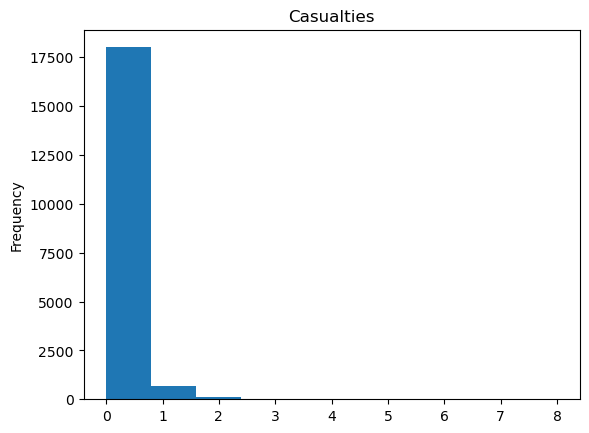

In [9]:
#################################################################################################
# scatter plots, boxplots, and histograms to visualize and to explore attribute characteristics #
#################################################################################################

facts['casualties'].plot(kind='hist', title='Casualties')
plt.show()

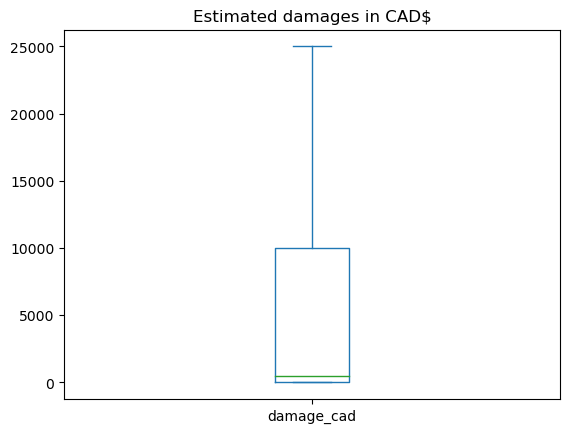

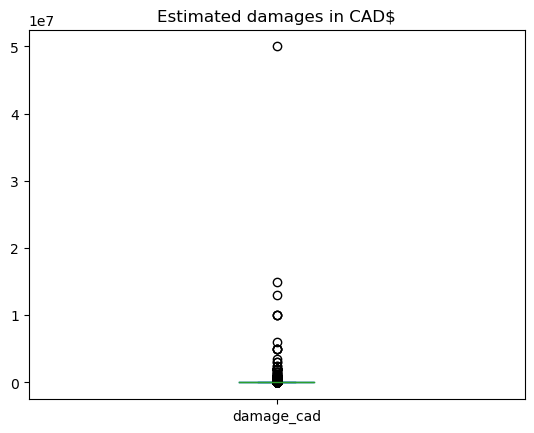

In [10]:
#Outliers removed for readability
facts['damage_cad'].plot(kind='box', title='Estimated damages in CAD$', showfliers=False)
plt.show()
facts['damage_cad'].plot(kind='box', title='Estimated damages in CAD$')
plt.show()

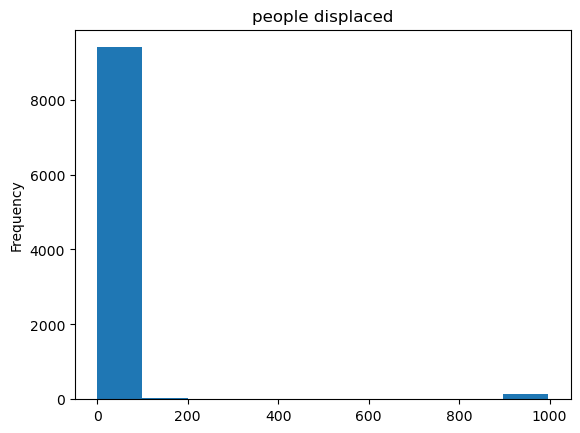

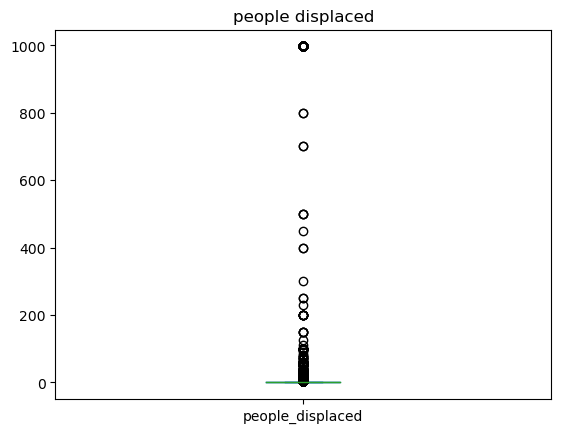

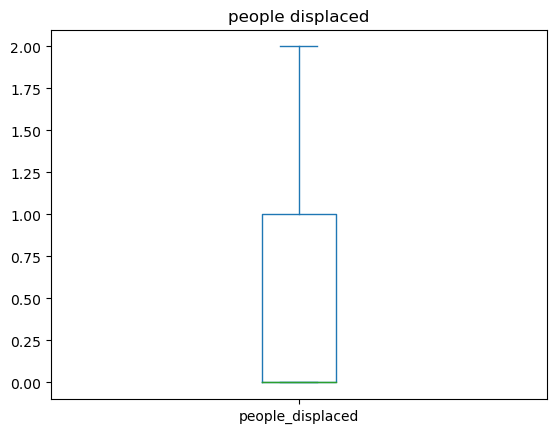

In [11]:
facts['people_displaced'].plot(kind='hist', title='people displaced')
plt.show()
facts['people_displaced'].plot(kind='box', title='people displaced')
plt.show()
facts['people_displaced'].plot(kind='box', title='people displaced',showfliers=False)
plt.show()

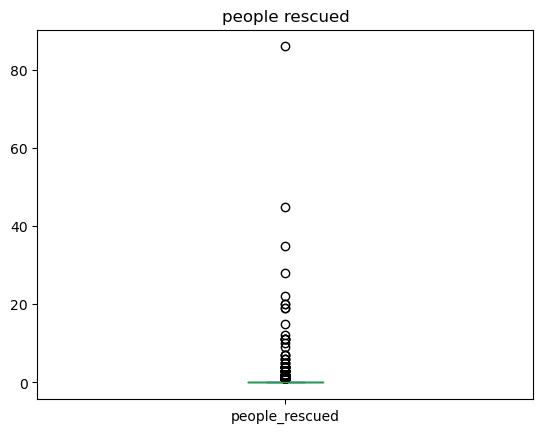

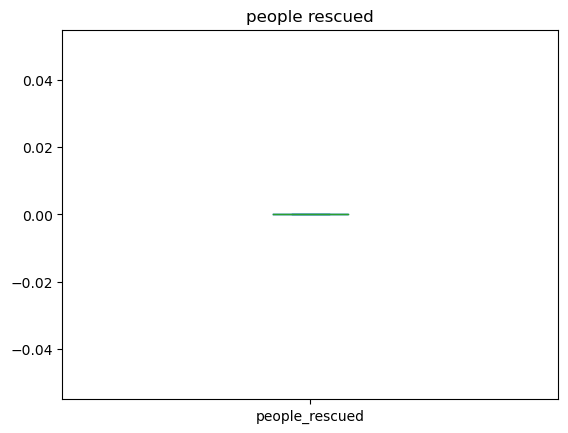

In [12]:
facts['people_rescued'].plot(kind='box', title='people rescued')
plt.show()
facts['people_rescued'].plot(kind='box', title='people rescued',showfliers=False)
plt.show()

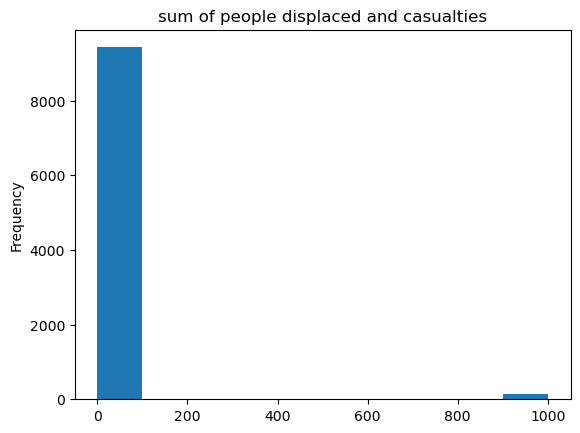

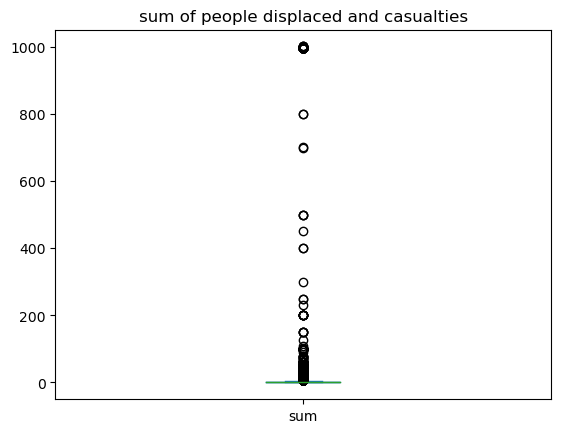

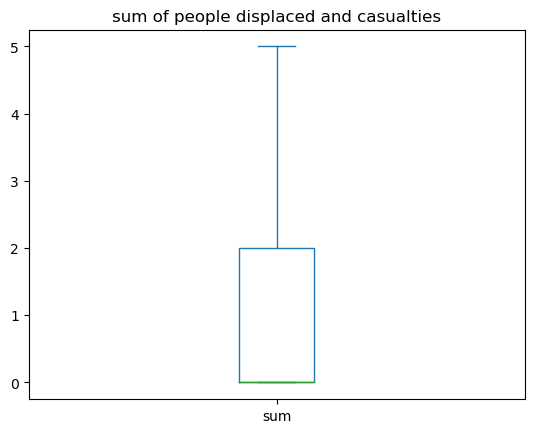

In [13]:
facts['sum']=facts['people_displaced']+facts['casualties']
facts['sum'].plot(kind='hist', title='sum of people displaced and casualties')
plt.show()
facts['sum'].plot(kind='box', title='sum of people displaced and casualties')
plt.show()
facts['sum'].plot(kind='box', title='sum of people displaced and casualties',showfliers=False)
plt.show()

<AxesSubplot:xlabel='casualties', ylabel='responding_personel'>

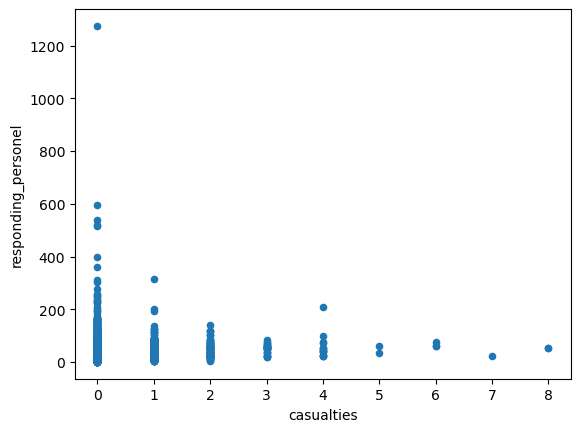

In [14]:

facts.plot.scatter(x='casualties', y='responding_personel')




<AxesSubplot:xlabel='casualties', ylabel='responding_apparatus'>

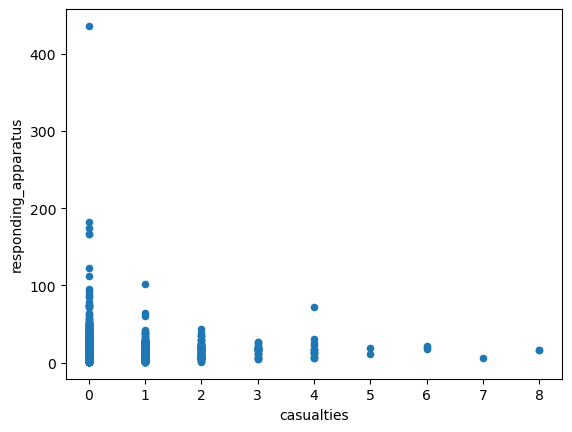

In [15]:
facts.plot.scatter(x='casualties', y='responding_apparatus')


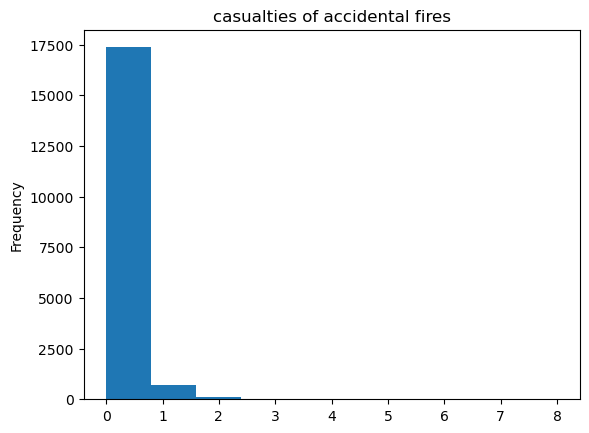

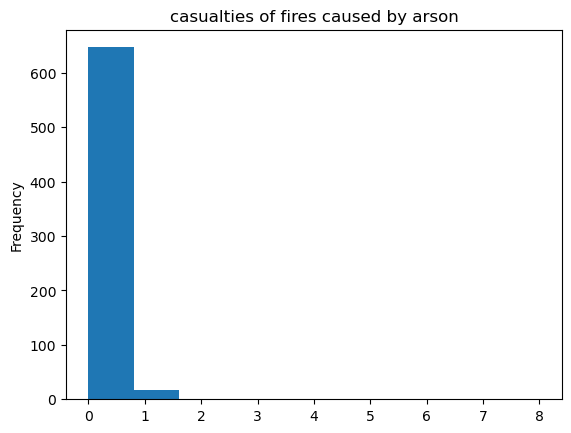

In [16]:
facts_unin=facts[facts['possible_cause']=='unintentional']
facts_unin['casualties'].plot(kind='hist', title='casualties of accidental fires')
plt.show()
facts_in=facts[facts['possible_cause']=='intentional']
facts_in['casualties'].plot(kind='hist', title='casualties of fires caused by arson')
plt.show()